In [ ]:
# sudo apt install msttcorefonts -qq
!rm ~/.cache/matplotlib -rf

In [1]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from sklearn import mixture
import hdbscan
import random
from tqdm import tqdm
plt.ion()
plt.show()
import os
import sys
sys.path.append("..")
from keras.models import Model
import time
from keras.models import load_model
import scripts.cnn_models as cnn_models
import scripts.internal_scores as validation
plt.style.use('publication_bigger.mplstyle')
plt.ion()
plt.show()
random_state=0
random.seed( random_state )
np.random.seed(random_state)
method = "adapted_ratkowsky_lance"

In [4]:
%load_ext autoreload
%autoreload 2

# Save GPU model weights



In [5]:
if os.path.isfile('models/cnn.ckpt') == False:
    model_file =  f'models/cnn.h5'
    model12d = load_model(model_file)

    def freeze_layers(model):
        for i in model.layers:
            i.trainable = False
            if isinstance(i, Model):
                freeze_layers(i)
        return model

    model_freezed = freeze_layers(model12d)
    model_freezed.save_weights('models/cnn.ckpt')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [5]:
def load_cpu_model(weights_file = 'models/cnn.ckpt'):
    input_shape = (21,2)
    params = {
        'filter_size': 20,
        'activation': 'relu',
        'dropout': 0.3,
        'optimizer': 'adam',
        'learningRate': 0.0001,
        'noise': 0.005,
        'regularization': True,
        'l2': 0.0005
    }
    model = cnn_models.build_2conv_model(input_shape,
                                     firstKernelSize=10,
                                     secondKernelSize=10,
                                     **params)
    model.load_weights(weights_file)
    return model

def nn_cpu_approximation(data, ids, weights_file =  f'models/cnn.ckpt'):
    digitized_data_1d = cnn_models.digitize(data)
    model12d = load_cpu_model(weights_file = 'models/cnn.ckpt')
    scores = cnn_models.predict(model12d, ids, digitized_data_1d)
    return scores
def nn_approximation(data, ids, n_clusters, model_file =  f'models/cnn.h5'):
    digitized_subspaces = cnn_models.digitize(data)
    
    model12d = load_model(model_file)
    scores = cnn_models.predict(model12d, ids, digitized_subspaces, n_clusters)
    return scores

def k_means_clustering(data, ids, n_clusters, algorithm):
    scores = []
    for i, j in ids:
        if algorithm == "gmm":
            gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
            pred = gmm.fit_predict(data[:, [i,j]])
        if algorithm == "hdbscan":
            pred = hdbscan.HDBSCAN(min_cluster_size =10).fit(data[:, [i,j]]).labels_
#         pred = KMeans(n_clusters= n_clusters, random_state = 0).fit(data[:, [i,j]]).labels_
        scores.append(getattr(validation.validation(), method)(data[:, [i,j]], pred))
    return scores

In [6]:
# results = pd.DataFrame(columns = ["Nb. evaluations",  "NN CPU time"])

# for size in [10, 20, 50, 100, 200, 300, 400]:
#     data = np.random.uniform(size = (300, size))
#     ids = np.array(list(itertools.combinations(np.arange(data.shape[1]), 2)))
#     print(len(ids), size)

#     t1 = time.time()
# #     nn_cpu_approximation(data, ids,  weights_file =  f'models/nn.ckpt')
# #     nn_approximation(data, ids, model_file =  f'models/nn_cpu.h5')
#     nn_approximation(data, ids, model_file =  f'models/nn.h5')
#     t2 = time.time()
#     nn_time = t2-t1

#     runs = [len(ids), nn_time]

#     results.loc[results.shape[0]] = runs
#     results.to_pickle("data/cpu_speed_comparaison.pkl")

In [7]:
# results = pd.DataFrame(columns = ["Nb. evaluations",  "NN GPU time"])

# for size in [10, 20, 50, 100, 200, 300, 400]:
#     data = np.random.uniform(size = (300, size))
#     ids = np.array(list(itertools.combinations(np.arange(data.shape[1]), 2)))
#     print(len(ids), size)

#     t1 = time.time()
#     nn_approximation(data, ids,2, model_file =  f'models/cnn.h5')
#     t2 = time.time()
#     nn_time = t2-t1

#     runs = [len(ids), nn_time]

#     results.loc[results.shape[0]] = runs
#     results.to_pickle("data/gpu_speed_comparaison_2D.pkl")

In [11]:
results = pd.DataFrame(columns = ["Nb. evaluations",  "NN time", "Clustering+Eval time (2 clusters)",
                                 "Clustering+Eval time (4 clusters)", "Clustering+Eval time (8 clusters)",
                                 "HDBSCAN"])

for size in [10, 20, 50, 100, 200, 300, 400]:
    data = np.random.uniform(size = (300, size))
    ids = np.array(list(itertools.combinations(np.arange(data.shape[1]), 2)))
    print(len(ids), size)



    t1 = time.time()
    nn_approximation(data, ids,4, model_file =  f'models/gmm_arl.h5')
    t2 = time.time()
    nn_time = t2-t1

    runs = [len(ids), nn_time]

    for n_clusters in [2,4,8]:
        t1 = time.time()
        k_means_clustering(data, ids, n_clusters, "gmm")
        t2 = time.time()
        clustering_time = t2-t1
        runs.append(clustering_time)
    t1 = time.time()
    k_means_clustering(data, ids, n_clusters, "hdbscan")
    t2 = time.time()
    clustering_time = t2-t1
    runs.append(clustering_time)
    results.loc[results.shape[0]] = runs
    results.to_pickle("data/speed_comparaison1.pkl")

45 10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


190 20
1225 50
4950 100
19900 200
44850 300
79800 400


In [56]:
results = pd.read_pickle("data/speed_comparaison1.pkl")
# results_cpu = pd.read_pickle("data/cpu_speed_comparaison.pkl")
# results_gpu = pd.read_pickle("data/gpu_speed_comparaison_2D.pkl")

In [57]:
results

,Nb. evaluations,NN time,Clustering+Eval time (2 clusters),Clustering+Eval time (4 clusters),Clustering+Eval time (8 clusters),HDBSCAN
0,45.0,2.538476,0.239320,0.473580,1.112989,0.372864
1,190.0,1.931027,1.034542,2.053211,4.383819,1.550917
2,1225.0,2.973912,6.925745,12.497273,28.710780,10.310775
3,4950.0,6.325443,26.664582,47.195092,109.879096,40.770614
4,19900.0,18.672531,109.429892,195.849726,456.737485,162.211112
5,44850.0,38.336599,255.990886,442.229201,1013.007849,366.364081
6,79800.0,65.190657,441.001237,768.034302,1774.023777,649.095406


In [58]:
results.columns

Index(['Nb. evaluations', 'NN time', 'Clustering+Eval time (2 clusters)',
       'Clustering+Eval time (4 clusters)',
       'Clustering+Eval time (8 clusters)', 'HDBSCAN'],
      dtype='object')

In [59]:
results = results.rename(
    columns={
        'Clustering+Eval time (2 clusters)': 'GMM+Eval time (2 clusters)',
        'Clustering+Eval time (4 clusters)': 'GMM+Eval time (4 clusters)',
        'Clustering+Eval time (8 clusters)': 'GMM+Eval time (8 clusters)',
        'HDBSCAN': 'HDBSCAN+Eval time'
    })
results.columns

Index(['Nb. evaluations', 'NN time', 'GMM+Eval time (2 clusters)',
       'GMM+Eval time (4 clusters)', 'GMM+Eval time (8 clusters)',
       'HDBSCAN+Eval time'],
      dtype='object')

In [60]:
results.dtypes

Nb. evaluations               float64
NN time                       float64
GMM+Eval time (2 clusters)    float64
GMM+Eval time (4 clusters)    float64
GMM+Eval time (8 clusters)    float64
HDBSCAN+Eval time             float64
dtype: object

In [61]:
for c in [
        'GMM+Eval time (2 clusters)', 'GMM+Eval time (4 clusters)',
        'GMM+Eval time (8 clusters)', 'HDBSCAN+Eval time'
    ]:

    results[c] /= results["NN time"]

** GMM+Eval time (2 clusters)
float64
** GMM+Eval time (4 clusters)
float64
** GMM+Eval time (8 clusters)
float64
** HDBSCAN+Eval time
float64


In [62]:
df = results[['Nb. evaluations',  'GMM+Eval time (2 clusters)', 'GMM+Eval time (4 clusters)',
        'GMM+Eval time (8 clusters)', 'HDBSCAN+Eval time']]
df

,Nb. evaluations,GMM+Eval time (2 clusters),GMM+Eval time (4 clusters),GMM+Eval time (8 clusters),HDBSCAN+Eval time
0,45.0,0.094277,0.186561,0.438448,0.146885
1,190.0,0.535747,1.063274,2.270200,0.803157
2,1225.0,2.328833,4.202301,9.654213,3.467075
3,4950.0,4.215449,7.461152,17.370972,6.445495
4,19900.0,5.860474,10.488654,24.460395,8.687152
5,44850.0,6.677454,11.535431,26.424041,9.556510
6,79800.0,6.764792,11.781355,27.212853,9.956878


In [80]:
def format_func(value, tick_number):
    barWidth = 0.2
    N = value - 1.5*barWidth
    if N == 0:
        return r"$\binom{10}{2}$" + "\n(45)"
    elif N == 1:
        return r"$\binom{20}{2}$" + "\n(190)"
    elif N == 2:
        return r"$\binom{50}{2}$" + "\n(1225)"
    elif N == 3:
        return r"$\binom{100}{2}$" + "\n(4950)"
    elif N == 4:
        return r"$\binom{200}{2}$" + "\n(19999)"
    elif N == 5:
        return r"$\binom{300}{2}$" + "\n(44850)"
    elif N == 6:
        return r"$\binom{400}{2}$" + "\n(79800)"



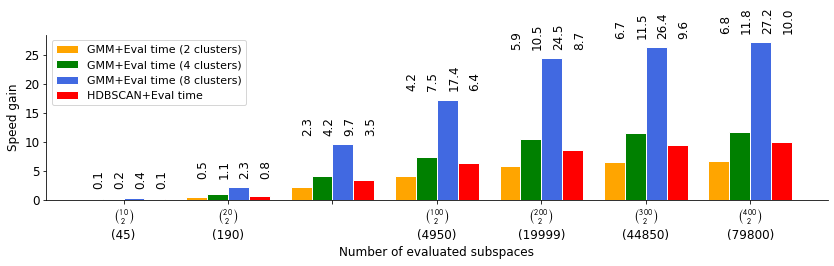

In [82]:
fig = plt.figure(figsize = (14, 4))
ax = plt.gca()
# set width of bar
barWidth = 0.2
 
# set height of bar
bars1 = results['GMM+Eval time (2 clusters)'].values
bars2 = results['GMM+Eval time (4 clusters)'].values
bars3 = results['GMM+Eval time (8 clusters)'].values
bars4 = results['HDBSCAN+Eval time'].values

bars = np.array([bars1, bars2, bars3, bars4])
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='orange', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (2 clusters)')
plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (4 clusters)')
plt.bar(r3, bars3, color='royalblue', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (8 clusters)')
plt.bar(r4, bars4, color='red', width=barWidth, edgecolor='white', 
        label='HDBSCAN+Eval time')

for i in range(bars.shape[1]):
    y = bars[:,i]
    y_pos = max(y)+ 2
    plt.text(i, y_pos, round(y[0],1), rotation = 90)
    plt.text(i + barWidth, y_pos, round(y[1],1),  rotation = 90)
    plt.text(i + 2*barWidth, y_pos, round(y[2],1),  rotation = 90)
    plt.text(i + 3*barWidth, y_pos, round(y[3],1),  rotation = 90)

# Add xticks on the middle of the group bars
plt.xlabel('Number of evaluated subspaces')
plt.xticks([r + 1.5*barWidth for r in range(len(bars1))], results['Nb. evaluations'].values.astype(int))
plt.ylabel("Speed gain")
# plt.suptitle("Number of times the network is faster than traditional clustering + evaluation" +
#     "\nOn exhausive 2D subspace exploration of datasets with 10, 20, 50, 100, 200, 300 and 400 features")
sns.despine()
# Create legend & Show graphic
plt.legend()
# plt.tight_layout()
fig.subplots_adjust(wspace=0.3, top = 0.7)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.savefig("images/NN_speed_comparaison.pdf", bbox_inches='tight')


In [74]:
results['Nb. evaluations'].values.astype(int)

array([   45,   190,  1225,  4950, 19900, 44850, 79800])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


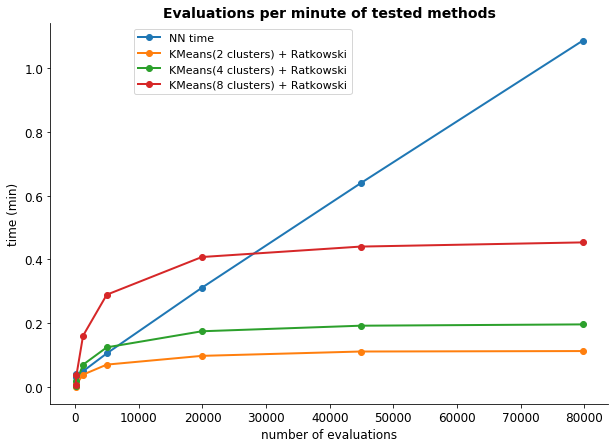

In [19]:
plt.figure(figsize=(10, 7))

ax = plt.gca()
f = 60
plt.plot(results['Nb. evaluations'],
         results['NN time']/f,
         label="NN time",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (2 clusters)']/f,
         label="KMeans(2 clusters) + Ratkowski",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (4 clusters)']/f,
         label="KMeans(4 clusters) + Ratkowski",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (8 clusters)']/f,
         label="KMeans(8 clusters) + Ratkowski",
         marker="o")

plt.title("Evaluations per minute of tested methods", fontweight="bold")
plt.xlabel("number of evaluations")
plt.ylabel("time (min)")
ax.legend(bbox_to_anchor=(0.55,1))

sns.despine()
plt.savefig("images/NN_vs_clustering_speed.pdf", bbox_inches='tight')

# Importance of Bio training

In [58]:
plot_df = pd.read_pickle("data/improvement_by_bio_training.pkl")

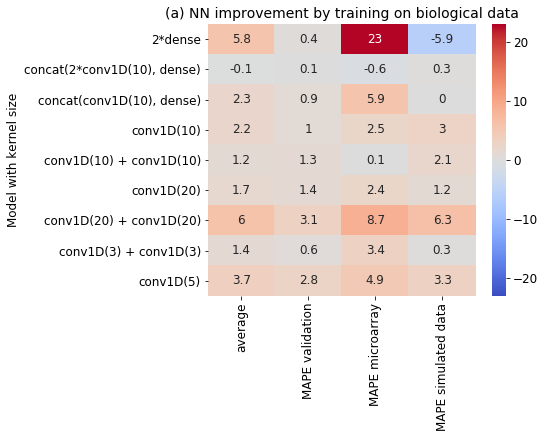

In [62]:
plt.figure(figsize = (6,5))
ax =  plt.subplot(111)

ax = plt.gca()

sns.heatmap( plot_df,
annot = True,cmap = "coolwarm", vmin = -23, vmax = 23,ax = ax)
plt.title("(a) NN improvement by training on biological data")
plt.savefig("images/bio_improvement.pdf", bbox_inches='tight')

# Make combined plot

In [57]:
plot_df = pd.read_pickle("data/improvement_by_bio_training.pkl")

In [ ]:
plt.figure(figsize = (16,7))
ax =  plt.subplot(121)

ax = plt.gca()

sns.heatmap( plot_df,
annot = True,cmap = "coolwarm", vmin = -23, vmax = 23,ax = ax)
plt.title("(a) NN improvement by training on biological data")

ax =  plt.subplot(122)

f = 60
plt.plot(results['Nb. evaluations'],
         results['NN time']/f,
         label="NN time",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (2 clusters)']/f,
         label="KMeans(2 clusters) + Ratkowski",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (4 clusters)']/f,
         label="KMeans(4 clusters) + Ratkowski",
         marker="o")
plt.plot(results['Nb. evaluations'],
         results['Clustering+Eval time (8 clusters)']/f,
         label="KMeans(8 clusters) + Ratkowski",
         marker="o")

plt.title("(b) Evaluations per minute for tested methods")
plt.xlabel("number of evaluations")
plt.ylabel("time (min)")
ax.legend(bbox_to_anchor=(0.62,1))
sns.despine()
plt.tight_layout()
plt.savefig("images/NN_speed_and_bio_improvement.pdf", bbox_inches='tight')